<a href="https://colab.research.google.com/github/karamathasan/BraTS/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Citations:

[1] B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al. "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)", IEEE Transactions on Medical Imaging 34(10), 1993-2024 (2015) DOI: 10.1109/TMI.2014.2377694

[2] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al., "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features", Nature Scientific Data, 4:170117 (2017) DOI: 10.1038/sdata.2017.117

[3] S. Bakas, M. Reyes, A. Jakab, S. Bauer, M. Rempfler, A. Crimi, et al., "Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge", arXiv preprint arXiv:1811.02629 (2018)

In addition, if there are no restrictions imposed from the journal/conference you submit your paper about citing "Data Citations", please be specific and also cite the following:

[4] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J. Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-GBM collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.KLXWJJ1Q

[5] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J. Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-LGG collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.GJQ7R0EF

# Code
## Setup and Install

In [ ]:
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
!pip install patchify

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import h5py
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Conv3D, Conv3DTranspose, Concatenate, MaxPooling3D

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
download_path = kagglehub.dataset_download("awsaf49/brats2020-training-data")

In [ ]:
csv_path = "/root/.cache/kagglehub/datasets/awsaf49/brats2020-training-data/versions/3/BraTS20 Training Metadata.csv"
data_path = "/root/.cache/kagglehub/datasets/awsaf49/brats2020-training-data/versions/3/BraTS2020_training_data/content/data"

In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,slice_path,target,volume,slice,label0_pxl_cnt,label1_pxl_cnt,label2_pxl_cnt,background_ratio
0,../input/brats2020-training-data/BraTS2020_tra...,0,41,0,0,0,0,1.0
1,../input/brats2020-training-data/BraTS2020_tra...,0,41,1,0,0,0,1.0
2,../input/brats2020-training-data/BraTS2020_tra...,0,41,2,0,0,0,1.0
3,../input/brats2020-training-data/BraTS2020_tra...,0,41,3,0,0,0,1.0
4,../input/brats2020-training-data/BraTS2020_tra...,0,41,4,0,0,0,1.0


In [ ]:
file_path = download_path + df.iloc[220]["slice_path"].split("../input/brats2020-training-data")[1]

In [ ]:
file_path

'/root/.cache/kagglehub/datasets/awsaf49/brats2020-training-data/versions/3/BraTS2020_training_data/content/data/volume_185_slice_65.h5'

In [ ]:
with h5py.File(file_path, 'r') as hdf:
    image = np.array(hdf["image"])
    mask = np.array(hdf["mask"])

  # each volume seems to be 154 x 240 x 240 x 4

In [ ]:
def normalize(image):
    min = image[np.unravel_index(np.argmin(image),image.shape)]
    max = image[np.unravel_index(np.argmax(image),image.shape)]
    if max == min:
        return image
    image = (image - min) / (max - min)
    return image

In [ ]:
image = normalize(image)
print(image.max(), image.min())

1.0 0.0


In [ ]:
mask.shape

(240, 240, 3)

In [ ]:
image_t1 = image[:,:,0]
image_t1gd = image[:,:,1]
image_t2 = image[:,:,2]
image_t2f = image[:,:,3]

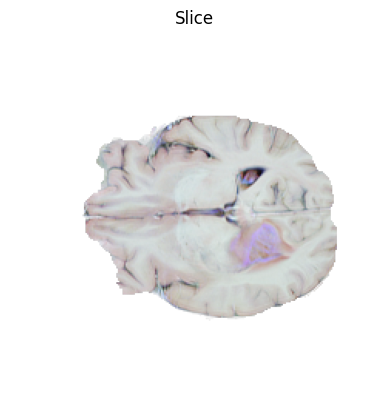

In [ ]:
# plt.imshow(normalize(image_t1), cmap='gray')
plt.imshow(image, cmap='gray')
plt.title("Slice")
plt.axis('off')
plt.show()

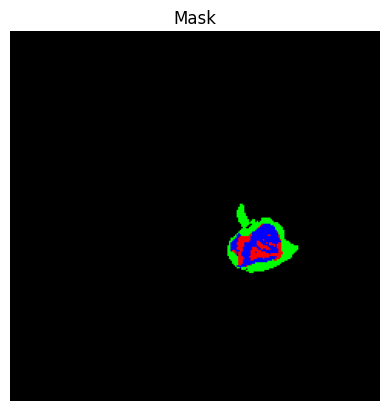

In [ ]:
plt.imshow(mask * 255)
plt.title("Mask")
plt.axis('off')
plt.show()

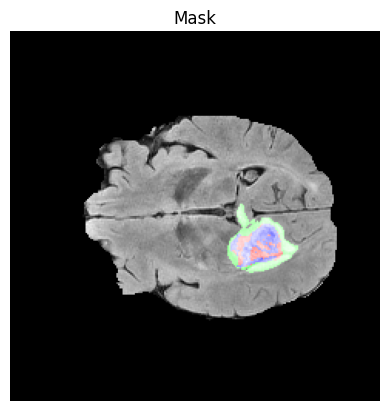

In [ ]:
plt.imshow(np.expand_dims(normalize(image_t1),axis=-1) + mask)
plt.title("Mask")
plt.axis('off')
plt.show()

In [ ]:
def get_slice(vol_idx, slice_idx):
    slice_path = data_path + f"/volume_{vol_idx}_slice_{slice_idx}.h5"
    with h5py.File(slice_path, 'r') as hdf:
        image = np.array(hdf["image"])
        mask = np.array(hdf["mask"])
    return image, mask

In [ ]:
def get_volume(vol_idx):
    volume_path = data_path + f"/volume_{vol_idx}"
    arr = []
    for i in range(154):
        slice_path = volume_path + f"_slice_{i}.h5"
        with h5py.File(slice_path, 'r') as hdf:
            image = np.array(hdf["image"])
        arr.append(image)
    image = normalize(image);
    return np.array(arr, dtype=np.float32)

In [ ]:
def get_volume_mask(vol_idx):
    volume_path = data_path + f"/volume_{vol_idx}"
    arr = []
    for i in range(154):
        slice_path = volume_path + f"_slice_{i}.h5"
        with h5py.File(slice_path, 'r') as hdf:
            mask = np.array(hdf["mask"])
        arr.append(mask)
    return np.array(arr, dtype=np.float32)

In [ ]:
test_vol = get_volume(41)
# D W H C

In [ ]:
patches = patchify(test_vol, (32, 32, 32, 4), step=32)
print(test_vol.shape)
print(patches.shape)

(154, 240, 240, 4)
(4, 7, 7, 1, 32, 32, 32, 4)


In [ ]:
def unpatchify_3d(patches, original_shape):
    """
    Unpatchify a 3D volume from patches, including padding if necessary.

    Args:
        patches: Tensor of shape (grid_depth, grid_height, grid_width, 1, patch_depth, patch_height, patch_width, num_channels)
        original_shape: Tuple (original_depth, original_height, original_width, num_channels)

    Returns:
        Tensor of shape (original_depth, original_height, original_width, num_channels)
    """
    # Extract dimensions
    grid_depth, grid_height, grid_width, _, patch_depth, patch_height, patch_width, num_channels = patches.shape
    original_depth, original_height, original_width, _ = original_shape

    # Reshape to grid layout
    patches = np.reshape(patches, (grid_depth, patch_depth, grid_height, patch_height, grid_width, patch_width, num_channels))
    patches = tf.transpose(patches, perm=[0, 2, 4, 1, 3, 5, 6])  # Align axes

    # Merge patches into a single volume
    volume = np.reshape(patches, (
        grid_depth * patch_depth,
        grid_height * patch_height,
        grid_width * patch_width,
        num_channels
    ))

    # Calculate required padding
    pad_depth = (original_depth - volume.shape[0]) // 2
    pad_height = (original_height - volume.shape[1]) // 2
    pad_width = (original_width - volume.shape[2]) // 2

    # Apply padding
    paddings = [
        [pad_depth, pad_depth + (original_depth % 2)],
        [pad_height, pad_height + (original_height % 2)],
        [pad_width, pad_width + (original_width % 2)],
        [0, 0]  # No padding for channels
    ]
    volume = tf.pad(volume, paddings, mode="CONSTANT", constant_values=0)

    return np.array(volume)

In [ ]:
unpatchify_3d(patches, test_vol.shape).shape

(154, 240, 240, 4)

# 3D U-net
here we we will implement architecture for a 3D U-net model.

U-net follows a series of convolution blocks, followed by pooling layers to reduce the volume dimensions

In [ ]:
def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def unet3d(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    ouptut = Conv3D(3, 1, padding="same", activation="softmax")(d4)

    return tf.keras.Model(inputs, ouptut)

In [ ]:
# activate TPU
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print("Running on TPU:", tpu.master())
except ValueError:
    print("TPU not found. Check runtime settings.")

Running on TPU: 


In [ ]:
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
with strategy.scope():
  model = unet3d((32, 32, 32, 4))

In [ ]:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1e-6
    flat_y_true = tf.keras.backend.flatten(y_true)
    flat_y_pred = tf.keras.backend.flatten(y_pred)
    return (2. * tf.keras.backend.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (tf.keras.backend.sum(flat_y_true) + tf.keras.backend.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

In [ ]:
with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss=dice_coefficient_loss, metrics=[dice_coefficient])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 32, 32, 32, 4)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_135 (Conv3D)       │ (None, 32, 32, 32, 64) │          6,976 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_128            │ (None, 32, 32, 32, 64) │              0 │ conv3d_135[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_136 (Conv3D)       │ (None, 32, 32, 32, 64) │        110,656 │ activation_128[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_129            │ (None, 32, 32, 32, 64) │              0 │ conv3d_136[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_33          │ (None, 16, 16, 16, 64) │              0 │ activation_129[0][0]   │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_137 (Conv3D)       │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_33[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_130            │ (None, 16, 16, 16,     │              0 │ conv3d_137[0][0]       │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_138 (Conv3D)       │ (None, 16, 16, 16,     │        442,496 │ activation_130[0][0]   │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_131            │ (None, 16, 16, 16,     │              0 │ conv3d_138[0][0]       │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_34          │ (None, 8, 8, 8, 128)   │              0 │ activation_131[0][0]   │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_139 (Conv3D)       │ (None, 8, 8, 8, 256)   │        884,992 │ max_pooling3d_34[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_132            │ (None, 8, 8, 8, 256)   │              0 │ conv3d_139[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_140 (Conv3D)       │ (None, 8, 8, 8, 256)   │      1,769,728 │ activation_132[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_133       

 Total params: 90,297,987 (344.46 MB)

 Trainable params: 90,297,987 (344.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unique_vols = df["volume"].unique()

In [ ]:
def train_each_vol(epochs_per_vol):
    i = 0
    combined_history = {'loss': [], 'val_loss': [], 'dice_coefficient': [], 'val_dice_coefficient': []}
    for vol in unique_vols:
        print(f"|   vol idx: {i}\n")

        vol_patches = patchify(get_volume(vol), (32, 32, 32, 4), step=32)
        mask_patches = patchify(get_volume_mask(vol), (32, 32, 32, 3), step=32)

        input_img = vol_patches.reshape(-1, 32, 32, 32, 4)
        input_mask = mask_patches.reshape(-1, 32, 32, 32, 3)

        X_train, X_test, y_train, y_test = train_test_split(input_img, input_mask, test_size=0.2, random_state=42)
        history = model.fit(X_train, y_train, epochs=epochs_per_vol, validation_data=(X_test, y_test))
        for key in history.history.keys():
            combined_history[key].extend(history.history[key])

        i += 1
    return combined_history

In [ ]:
with strategy.scope():
    history = train_each_vol(5)

vol idx: 0
Epoch 1/5
5/5 [==============================] - 2s 374ms/step - loss: 0.9867 - dice_coefficient: 0.0380 - val_loss: 0.9589 - val_dice_coefficient: 0.0261
Epoch 2/5
5/5 [==============================] - 1s 298ms/step - loss: 0.9866 - dice_coefficient: 0.0381 - val_loss: 0.9589 - val_dice_coefficient: 0.0261
Epoch 3/5
5/5 [==============================] - 2s 339ms/step - loss: 0.9866 - dice_coefficient: 0.0381 - val_loss: 0.9589 - val_dice_coefficient: 0.0261
Epoch 4/5
5/5 [==============================] - 2s 338ms/step - loss: 0.9866 - dice_coefficient: 0.0381 - val_loss: 0.9589 - val_dice_coefficient: 0.0261
Epoch 5/5
5/5 [==============================] - 1s 291ms/step - loss: 0.9866 - dice_coefficient: 0.0381 - val_loss: 0.9589 - val_dice_coefficient: 0.0261


TypeError: Cannot convert the argument `type_value`: 0.9866597056388855 to a TensorFlow DType.